In [223]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import matplotlib.pyplot as plt
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [224]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.optim import Optimizer, Adam
from torch.types import Number
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision.utils import make_grid
from torchvision.transforms import Compose, ToTensor, Resize, Normalize
from torchvision.datasets import ImageFolder
import torchvision.models as models

In [225]:
from typing import cast, Any, overload, Generic
from typing_extensions import TypeVar
from matplotlib.figure import Figure
from matplotlib.axes import Axes

T_co = TypeVar("T_co", covariant=True, default=Tensor)

In [226]:
from tqdm.notebook import tqdm

In [227]:
project_name = "project-plant-identification"

In [228]:
from modules.dataset import (
    DATASET_BASEDIR,
    DATASET_DIR,
    DATASET_AUGMENTED_DIR,
    DATASET_ORIG_DIR,
    UNIQUE_PLANTS,
)


os.listdir(DATASET_BASEDIR)

['Flavia', 'New Plant-Dataset']

In [229]:
os.listdir(DATASET_DIR)

['augmented', 'original', 'valid']

In [230]:
os.listdir(DATASET_AUGMENTED_DIR)

['Arjun Leaf',
 'Curry Leaf',
 'Marsh Pennywort Leaf',
 'Mint Leaf',
 'Neem Leaf',
 'Rubble Leaf',
 'Z']

In [231]:
print("Number of Unique Plants: ", len(UNIQUE_PLANTS))
print("Unique Plants: ", UNIQUE_PLANTS)

Number of Unique Plants:  7
Unique Plants:  ['Arjun Leaf', 'Curry Leaf', 'Marsh Pennywort Leaf', 'Mint Leaf', 'Neem Leaf', 'Rubble Leaf', 'Z']


In [232]:
from modules.preprocess import SubtractBackground

# Define desired height and width
desired_height = 128
desired_width = 128

RESIZE = Resize((desired_height, desired_width))
NORMALIZE = Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

# Define transformation
TRANSFORM: "Compose[Tensor]" = Compose(
    [
        # SubtractBackground(),
        RESIZE,
        ToTensor(),
        NORMALIZE,
    ]
)

In [233]:
dataset = ImageFolder(str(DATASET_AUGMENTED_DIR), transform=TRANSFORM)
orig_ds = ImageFolder(str(DATASET_ORIG_DIR), transform=TRANSFORM)

In [234]:
print("Number of training images: ", len(dataset))
print("Number of original images: ", len(orig_ds))

Number of training images:  11270
Number of original images:  1380


In [235]:
num_classes = dataset.classes
print("Number of classes: ", len(num_classes))
print(*num_classes, sep="\n")

Number of classes:  7
Arjun Leaf
Curry Leaf
Marsh Pennywort Leaf
Mint Leaf
Neem Leaf
Rubble Leaf
Z


In [236]:
print(*orig_ds.classes, sep="\n")

Arjun Leaf
Curry Leaf
Marsh Pennywort Leaf
Mint Leaf
Neem Leaf
Rubble Leaf


Image shape: torch.Size([3, 128, 128])
Image Label:  0
Image Label:  Arjun Leaf


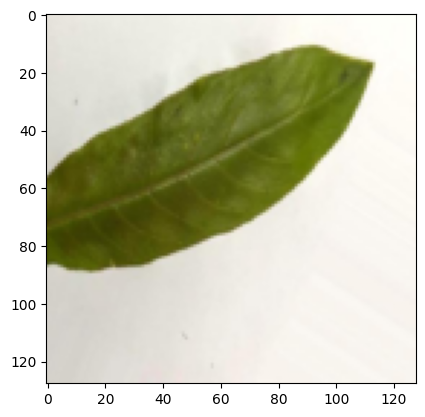

In [237]:
image, label = dataset[0]
print("Image shape:", image.shape)
print("Image Label: ", label)
print("Image Label: ", num_classes[label])
plt.imshow((image / 2 + 0.5).permute(1, 2, 0))

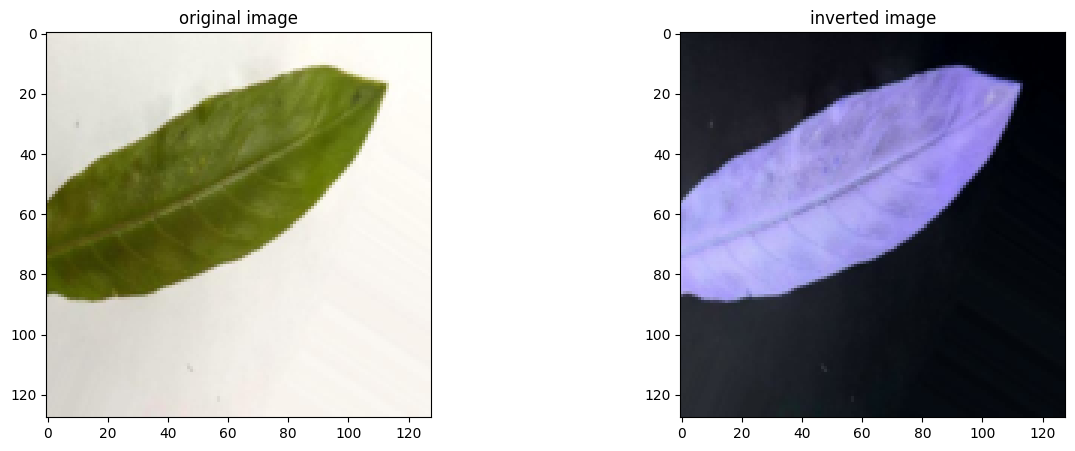

In [238]:
fig, (ax1, ax2) = cast(
    tuple[Figure, tuple[Axes, Axes]], plt.subplots(figsize=(15, 5), nrows=1, ncols=2)
)
unnormalized_image = image / 2 + 0.5
ax1.imshow(unnormalized_image.permute(1, 2, 0))
ax1.set_title("original image")
ax2.imshow(1 - unnormalized_image.permute(1, 2, 0))
ax2.set_title("inverted image")
plt.show()

In [239]:
random_seed = 42
torch.manual_seed(random_seed)  # type: ignore

In [240]:
validation_split = 0.3
val_size = int(len(dataset) * validation_split)
train_size = len(dataset) - val_size

TRAIN_DATASET, TEST_DATASET = random_split(dataset, (train_size, val_size))

In [241]:
batch_size = 64

TRAIN_LOADER = DataLoader(
    TRAIN_DATASET, batch_size=batch_size, num_workers=2, shuffle=True, pin_memory=True
)
TEST_LOADER = DataLoader(
    TEST_DATASET, batch_size=batch_size, num_workers=2, shuffle=True, pin_memory=True
)
ORIG_LOADER = DataLoader(
    orig_ds, batch_size=batch_size, num_workers=2, shuffle=True, pin_memory=True
)

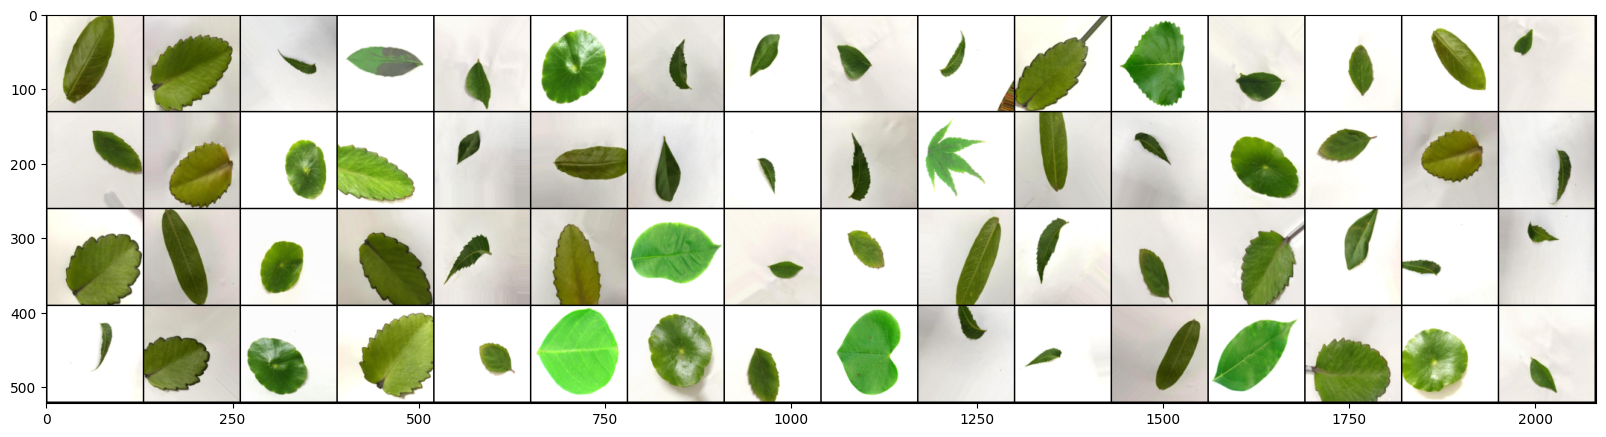

In [242]:
for images, labels in TRAIN_LOADER:
    fig, ax = plt.subplots(figsize=(20, 8))
    ax.imshow(make_grid(images / 2 + 0.5, nrow=16).permute(1, 2, 0))
    break

In [243]:
def accuracy(outputs: Tensor, labels: Tensor):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [244]:
class ImageClassificationBase(nn.Module):
    def __init__(self, *args: Any, **kwargs: Any) -> None:
        super().__init__(*args, **kwargs)  # type: ignore

    def training_step(self, batch: Tensor | list[Tensor]):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch: Tensor | list[Tensor]):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {"val_loss": loss, "val_acc": acc}

    def validation_epoch_end(self, outputs: list[dict[str, Tensor]]):
        batch_loss = [out["val_loss"] for out in outputs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [out["val_acc"] for out in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}

    def epoch_end(self, epoch: int, result: dict[str, Number]):
        print(
            "Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
                epoch, result["train_loss"], result["val_loss"], result["val_acc"]
            )
        )

In [245]:
class Herbal_Identification_Model(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output : 64*64*64
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output : 128*32*32
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output : 256*16*16
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output : 512*8*8
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output : 1024*4*4
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 38),
        )

    def forward(self, xb: Tensor) -> Tensor:
        out = self.network(xb)
        return out

In [246]:
class Herbal_Identification_Model1(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = models.vgg16(pretrained=True)
        num_ftrs = self.network.classifier[-1].in_features
        self.network.classifier[-1] = nn.Linear(num_ftrs, 38)

    def forward(self, xb: Tensor) -> Tensor:
        out = self.network(xb)
        return out

In [247]:
class Herbal_Identification_Model2(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = models.resnet34(pretrained=True)
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 38)

    def forward(self, xb: Tensor) -> Tensor:
        out = self.network(xb)
        return out

In [249]:
from modules.device import DEVICE


DEVICE

device(type='cuda')

In [250]:
T = TypeVar("T", bound=Tensor | nn.Module)


@overload
def to_device(data: list[T] | tuple[T, ...], device: str | torch.device) -> list[T]: ...
@overload
def to_device(data: T, device: str | torch.device) -> T: ...


def to_device(
    data: T | list[T] | tuple[T, ...], device: str | torch.device
) -> list[T] | T:
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [x.to(device, non_blocking=True) for x in data]
    return data.to(device, non_blocking=True)

In [251]:
class DeviceDataLoader(Generic[T_co]):
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl: DataLoader[T_co], device: str | torch.device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        b: list[Tensor]
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [252]:
TRAIN_LOADER = DeviceDataLoader(TRAIN_LOADER, DEVICE)
TEST_LOADER = DeviceDataLoader(TEST_LOADER, DEVICE)
ORIG_LOADER = DeviceDataLoader(ORIG_LOADER, DEVICE)

In [253]:
model = to_device(Herbal_Identification_Model2(), DEVICE)

In [254]:
model

Herbal_Identification_Model2(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, a

In [255]:
@torch.no_grad()  # type: ignore
def evaluate(model: ImageClassificationBase, val_loader: DeviceDataLoader[Any]):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [256]:
def fit(
    epochs: int,
    model: ImageClassificationBase,
    train_loader: DeviceDataLoader[Any],
    val_loader: DeviceDataLoader[Any],
    optimizer: Optimizer,
):
    history: list[dict[str, Number]] = []
    for epoch in range(epochs):
        model.train()
        train_losses: list[Tensor] = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()  # type: ignore
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model, val_loader)
        result["train_loss"] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [257]:
history = fit(10, model, TRAIN_LOADER, TEST_LOADER, Adam(model.parameters(), 0.001))

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.1734, val_loss: 0.0994, val_acc: 0.9738


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.0569, val_loss: 0.2930, val_acc: 0.9304


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.0607, val_loss: 0.0081, val_acc: 0.9976


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.0199, val_loss: 0.1976, val_acc: 0.9332


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.0457, val_loss: 0.0076, val_acc: 0.9976


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.0123, val_loss: 0.0828, val_acc: 0.9748


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.0796, val_loss: 0.0087, val_acc: 0.9976


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.0316, val_loss: 0.1350, val_acc: 0.9503


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.0144, val_loss: 0.0042, val_acc: 0.9985


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.0130, val_loss: 0.0100, val_acc: 0.9971


In [258]:
evaluate(model, TEST_LOADER)

{'val_loss': 0.009986241348087788, 'val_acc': 0.9970518946647644}

In [259]:
history = fit(5, model, TRAIN_LOADER, TEST_LOADER, Adam(model.parameters(), 0.001))

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.0467, val_loss: 0.0141, val_acc: 0.9968


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.0098, val_loss: 0.0039, val_acc: 0.9991


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.0193, val_loss: 0.1332, val_acc: 0.9731


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.0320, val_loss: 0.0227, val_acc: 0.9932


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.0241, val_loss: 0.0094, val_acc: 0.9968


In [260]:
def plot_losses(history: list[dict[str, Number]]):
    train_losses = [x["train_loss"] for x in history]
    val_losses = [x["val_loss"] for x in history]
    plt.plot(train_losses, "-bx")
    plt.plot(val_losses, "-rx")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend(["Training", "Validation"])
    plt.title("Loss vs. No. of epochs")

In [261]:
def plot_accuracies(history: list[dict[str, Number]]):
    accuracies = [x["val_acc"] for x in history]
    plt.plot(accuracies, "-x")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title("Accuracy vs. No. of epochs")

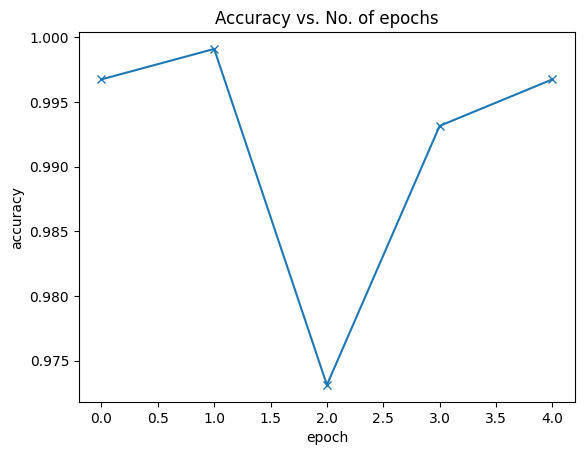

In [262]:
plot_accuracies(history)

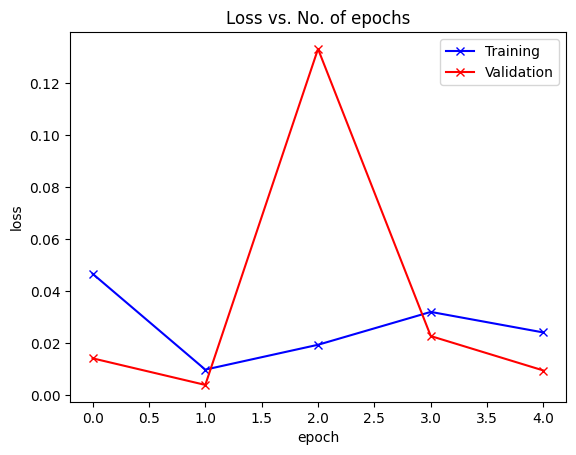

In [263]:
plot_losses(history)

In [264]:
evaluate(model, TEST_LOADER)

{'val_loss': 0.009440068155527115, 'val_acc': 0.9967570900917053}

In [265]:
x = evaluate(model, ORIG_LOADER)
x

{'val_loss': 0.005859781056642532, 'val_acc': 0.9978693127632141}

In [266]:
def predict_image(img: Tensor, model: ImageClassificationBase):
    xb = to_device(img.unsqueeze(0), DEVICE)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    i = cast(int, preds[0].item())
    print(i, type(i))
    return dataset.classes[i]

0 <class 'int'>
Label: Arjun Leaf , Predicted: Arjun Leaf


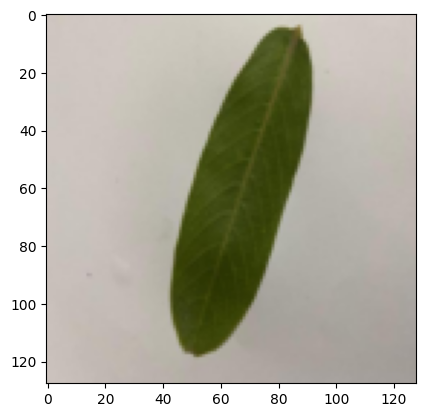

In [267]:
img, label = orig_ds[25]
plt.imshow((img / 2 + 0.5).permute(1, 2, 0))
print("Label:", dataset.classes[label], ", Predicted:", predict_image(img, model))

1 <class 'int'>
Label: Curry Leaf , Predicted: Curry Leaf


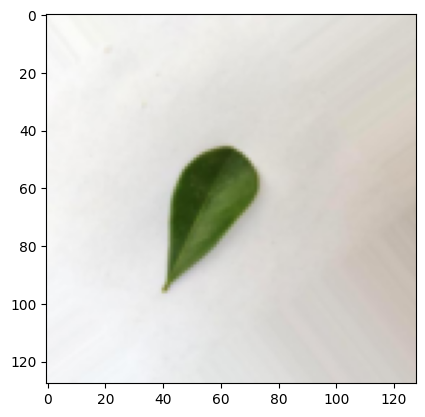

In [268]:
img, label = TRAIN_DATASET[25]
plt.imshow((img / 2 + 0.5).permute(1, 2, 0))
print("Label:", dataset.classes[label], ", Predicted:", predict_image(img, model))

4 <class 'int'>
Label: Neem Leaf , Predicted: Neem Leaf


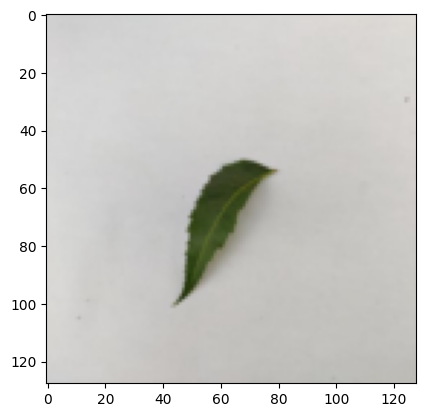

In [269]:
img, label = orig_ds[978]
plt.imshow((img / 2 + 0.5).permute(1, 2, 0))
print("Label:", dataset.classes[label], ", Predicted:", predict_image(img, model))

1 <class 'int'>
Label: Curry Leaf , Predicted: Curry Leaf


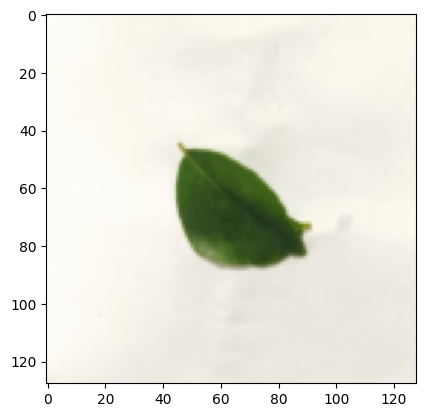

In [270]:
img, label = orig_ds[258]
plt.imshow((img / 2 + 0.5).permute(1, 2, 0))
print("Label:", dataset.classes[label], ", Predicted:", predict_image(img, model))

In [271]:
print(len(orig_ds))

1380


In [272]:
for i in range(len(orig_ds)):
    path, target = orig_ds.samples[i]
    print("Sample {}: Path: {}, Target: {}".format(i, path, target))

Sample 0: Path: D:\.R5-3600-Desktop\Documents\Code\ACLC-Butuan\Other\Herbal-Identification\dataset\New Plant-Dataset\original\Arjun Leaf\Arjun Leaf (1).JPG, Target: 0
Sample 1: Path: D:\.R5-3600-Desktop\Documents\Code\ACLC-Butuan\Other\Herbal-Identification\dataset\New Plant-Dataset\original\Arjun Leaf\Arjun Leaf (10).JPG, Target: 0
Sample 2: Path: D:\.R5-3600-Desktop\Documents\Code\ACLC-Butuan\Other\Herbal-Identification\dataset\New Plant-Dataset\original\Arjun Leaf\Arjun Leaf (100).JPG, Target: 0
Sample 3: Path: D:\.R5-3600-Desktop\Documents\Code\ACLC-Butuan\Other\Herbal-Identification\dataset\New Plant-Dataset\original\Arjun Leaf\Arjun Leaf (101).JPG, Target: 0
Sample 4: Path: D:\.R5-3600-Desktop\Documents\Code\ACLC-Butuan\Other\Herbal-Identification\dataset\New Plant-Dataset\original\Arjun Leaf\Arjun Leaf (102).JPG, Target: 0
Sample 5: Path: D:\.R5-3600-Desktop\Documents\Code\ACLC-Butuan\Other\Herbal-Identification\dataset\New Plant-Dataset\original\Arjun Leaf\Arjun Leaf (103).JPG,

In [273]:
torch.save(model.state_dict(), "../models/herbal-identification-new-resnet34.pth")

In [274]:
x = [x]

# Check the content and structure of x
print(x)

# Verify the data type of x[0]
print(type(x[0]))

# Assuming x[0] is a dictionary, access the keys 'val_acc' and 'val_loss'
if isinstance(x[0], dict):
    test_acc = x[0].get("val_acc")
    test_loss = x[0].get("val_loss")
    print("Test Accuracy:", test_acc)
    print("Test Loss:", test_loss)
else:
    print("x[0] is not a dictionary as expected.")

[{'val_loss': 0.005859781056642532, 'val_acc': 0.9978693127632141}]
<class 'dict'>
Test Accuracy: 0.9978693127632141
Test Loss: 0.005859781056642532


In [275]:
if isinstance(x[0], dict):
    test_acc = x[0].get("val_acc")
    test_loss = x[0].get("val_loss")
    print("Test Accuracy:", test_acc)
    print("Test Loss:", test_loss)
elif isinstance(x[0], str):
    print("Evaluation result is a string:", x[0])
    # Handle the string result accordingly
else:
    print("Unexpected type for x[0]:", type(x[0]))

Test Accuracy: 0.9978693127632141
Test Loss: 0.005859781056642532
